#  Classification Model of Student Anxiety and Depression
INTRODUCTION

**Anxiety** : the Indonesian Ministry of Health said Anxiety disorder is a psychological condition when a person experiences excessive anxiety that is constant and difficult to control, resulting in a negative impact on his daily life.Meanwhile, physical symptoms that may accompany anxiety disorders include:

* Hard to sleep 
* Body shaking
* Excessive sweating
* Muscles get tense
* Heart beat

**Depression** : p2ptm the Indonesian Ministry of Health said that depression can be marked by a prolonged feeling of sadness and loss of interest in activities that we usually do happily. The next sign is to stop doing your usual daily activities for at least two weeks.The following are some of the psychological symptoms of someone who is depressed:

* Loss of interest or motivation to do something.
* Constantly feeling sad, even crying constantly.
* Feeling very guilty and worrying too much.
* Unable to enjoy life because of loss of self-confidence.
* Hard to make decisions and easily offended.


**In this notebook, I tried to made a students anxiety and depression classify model**

********************************************************************* 

**Importing library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import re
import string
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**Load Datasets**

In [ ]:
# Load and read dataset using pandas 
df = pd.read_excel('dataset.xlsx',header = 0, index_col= None)
df.head(5)

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0


**What we get**

Consists of two columns containing text and labels depressed and not depressed. 

Label 1 = Depresi

Label 0 = NonDepresi


In [ ]:
# Data Outline
print("Dataset shape:  {}".format(df.shape))

Dataset shape:  (6982, 2)


In [ ]:
# Information about features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6982 entries, 0 to 6981
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    6972 non-null   object 
 1   label   6980 non-null   float64
dtypes: float64(1), object(1)
memory usage: 109.2+ KB


In [ ]:
# Searching for null-data
df.isnull().sum()

text     10
label     2
dtype: int64

In [ ]:
# drop 
df=df.dropna(how='any')

In [ ]:
# Count the label
df.groupby("label").count().style.background_gradient(cmap = "summer")

,text
label,
0.0,6240
1.0,730


This **Outlier data** is an observational data that raises values ​​that are excessive or exceed the limit and are far different from data that is still included in a sub-set of data.

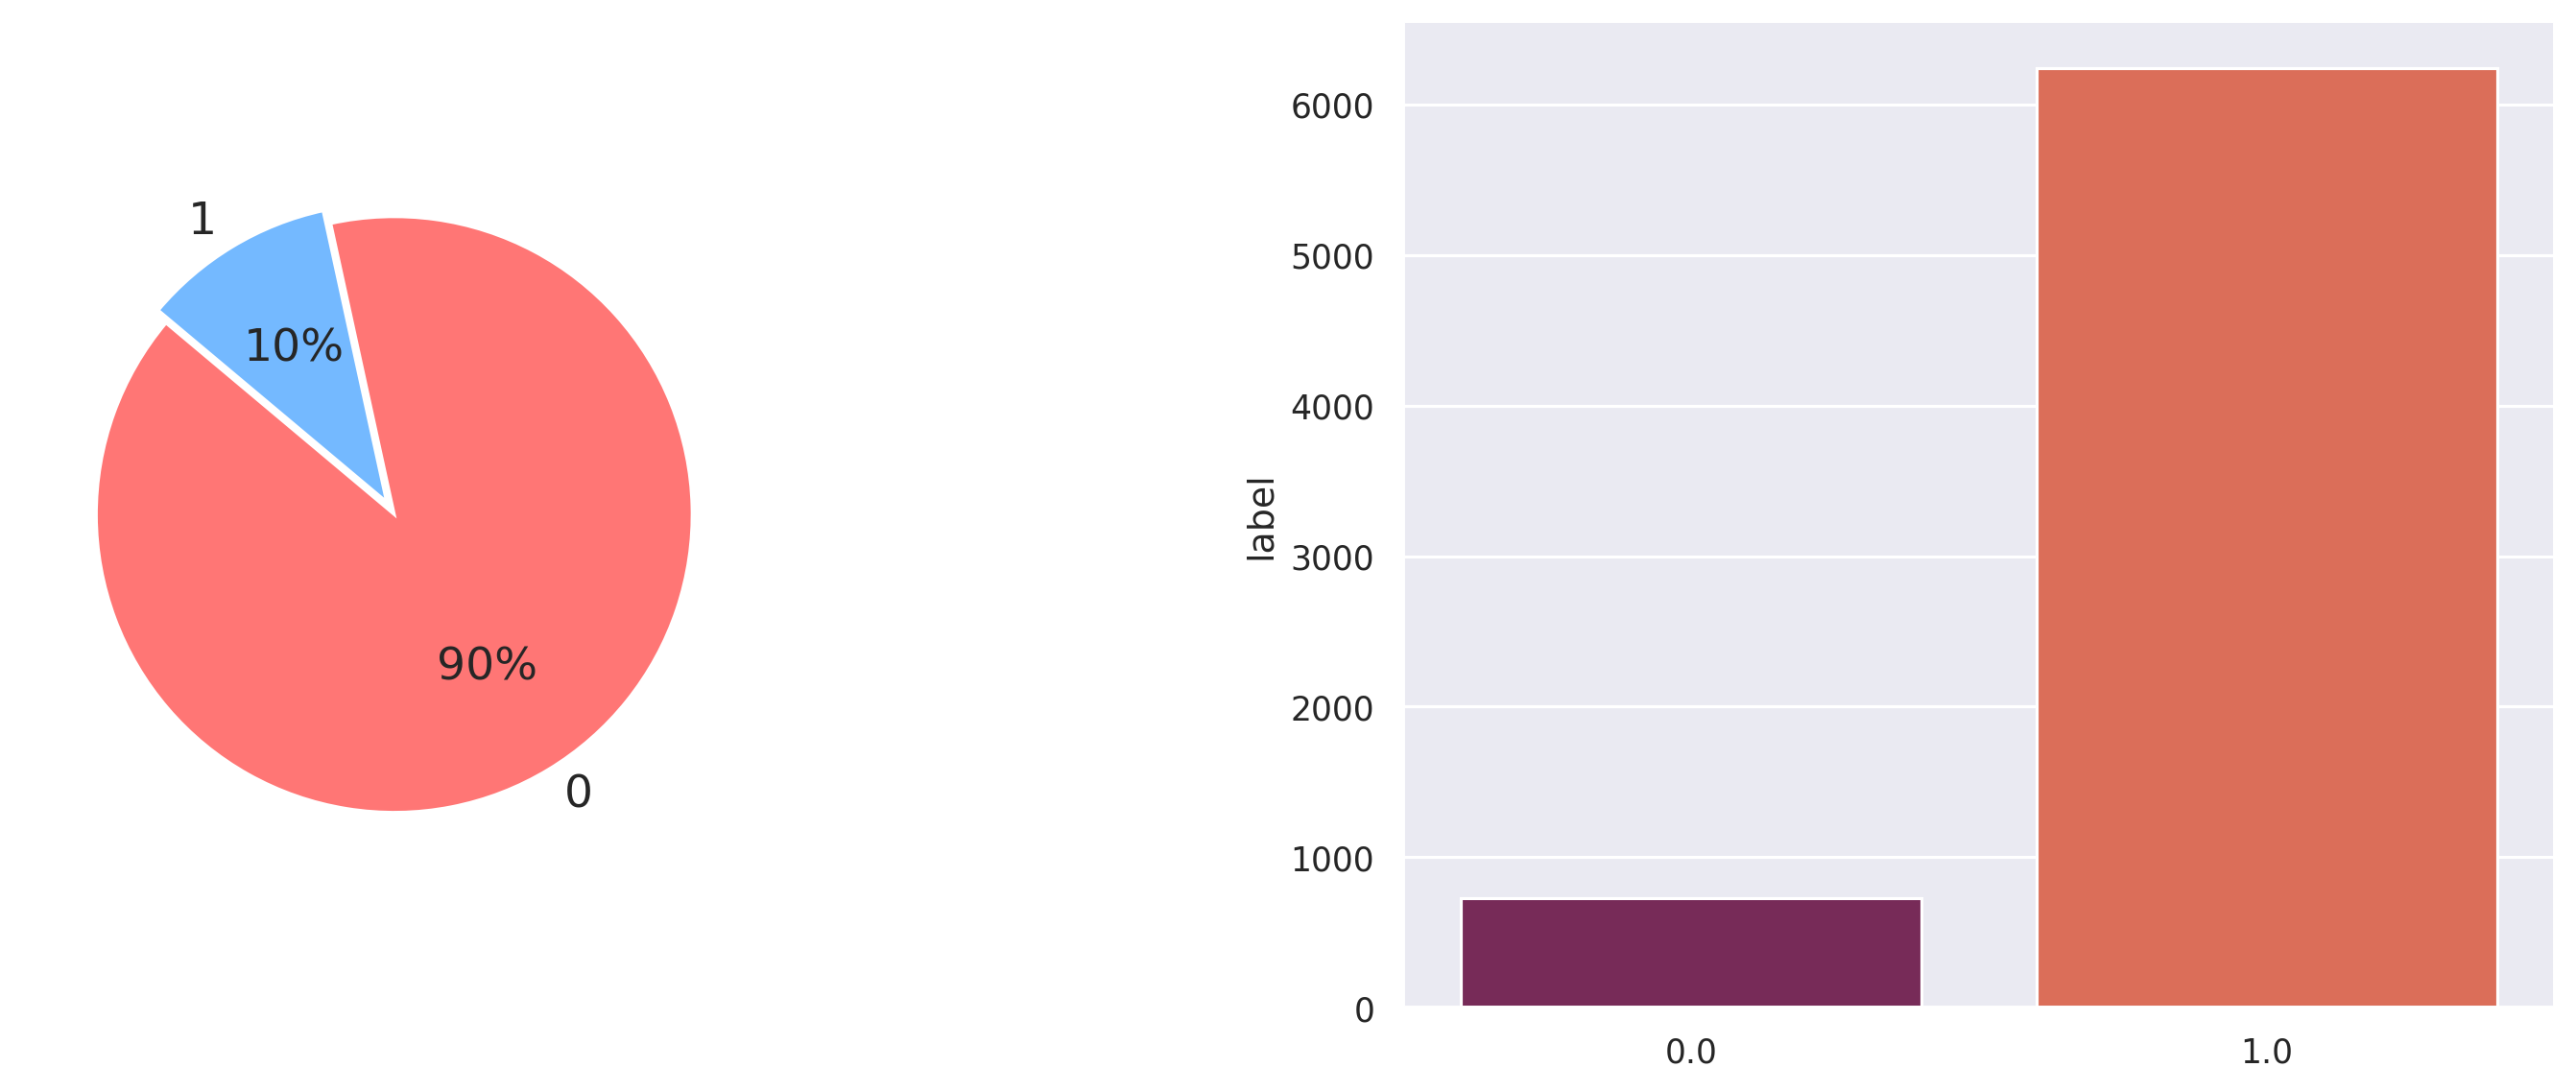

In [ ]:
# Visualize label 
labels = [0,1]
sizes = [6240, 730]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(15, 6), dpi=227)
plt.subplot(1, 3, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])

plt.subplot(1, 2, 2)
sns.barplot(x = df['label'].unique(), y = df['label'].value_counts(), palette= 'rocket')

plt.show()

**Features Engineering**

In [ ]:
# Adds a character length column

df['Total Words'] = df['text'].apply(lambda x: len(x.split()))

def length_word(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

df['Length Chars'] = df["text"].apply(length_word)

In [ ]:
# Ensure after adding coloumn
df.sample(5)

,text,label,Total Words,Length Chars
6583,"Oc want to see you this evening, please talk a...",0.0,14,55
683,"I'm nervous, worried but I don't know why",1.0,8,34
3349,Dasom here who is there?? (â•â˜žÂ´à¸´âˆ€Â´à¸´)...,0.0,6,46
5405,It's nice to have a friend who can make you sm...,0.0,18,68
6484,"Oh my gosh, until now, I still can't believe t...",0.0,15,60


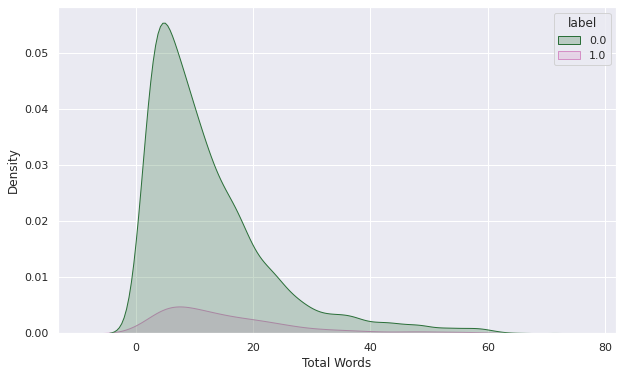

In [ ]:
# Visualize total words and label 
plt.figure(figsize = (10, 6))
sns.kdeplot(x = df['Total Words'], hue= df['label'], palette= "cubehelix", shade = True)
plt.show()

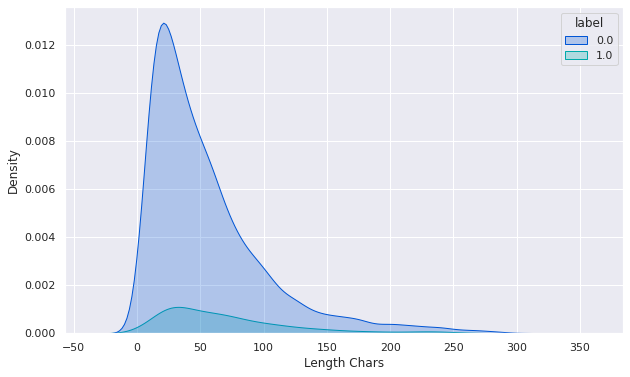

In [ ]:
# Visualize length chars and label 
plt.figure(figsize = (10, 6))
sns.kdeplot(x = df['Length Chars'], hue= df['label'], palette= 'winter', shade = True)
plt.show()

**Text Preprocessing**

*   Lowercase
*   Removing puctuation and url
*   Stopwords removal
*   Stemming



In [ ]:
df.sample(10)

,text,label,Total Words,Length Chars
4156,oh god that's dictation au anyway... i think i...,0.0,15,73
3239,This year's Eid I prefer to buy makeup and ski...,0.0,14,69
4864,Praise GodðŸ˜‡,0.0,2,13
4394,rip jyp que,0.0,3,9
5611,"-May I ask, hehe. Which album is Everlasting S...",0.0,20,105
4764,In addition to the store for those of you who ...,0.0,24,116
4095,Grta mentirosa mds â€ â™€ï¸,0.0,5,23
3057,Gluruk without reinforcements.. Lanjotttt...,0.0,4,41
1778,Who here has 100% exchanged to Telegram instea...,0.0,12,63
4024,"Ambitious! It's mutual, who's going to take it...",0.0,27,150


In [ ]:
# Convert text into lower case
# ex : Want/WILL/YEAH into want/will/yeah

def lowercase(text):
    text = text.lower()
    return text

df['text'] = df['text'].apply(lowercase)

In [ ]:
# Removing punctuation and link
def delete_url(text):
    read_url = re.compile('https?://\S+|www\.\S+')
    return read_url.sub('', text)

df['text'] = df['text'].apply(delete_url)

exclude = string.punctuation

def delete_punc(text):
    return text.translate(str.maketrans('', '', exclude))

df['text'] = df['text'].apply(delete_punc)

**Filtering (Stopword Removal)** : Filtering is the stage of taking important words from the token results by using a stoplist algorithm (discarding less important words) or wordlist (saving important words).

In [ ]:
import nltk
nltk.download('punkt')

# Do this in your ipython notebook or analysis script
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#removal stopwords
def removal_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

df['text'] = df['text'].apply(removal_stopwords)

**Stemming** is the process of removing the inflection of a word into its basic form, but the basic form does not mean the same as the root word. For example the word "listen", "listen", "listen to" will be transformed into the word "listen".

In [ ]:
def word_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

df['text'] = df['text'].apply(word_stemming)

In [ ]:
df['Total Words After Transformation'] = df['text'].apply(lambda x: np.log(len(x.split())))

# Ensure after processing
df.sample(5)

,text,label,Total Words,Length Chars,Total Words After Transformation
3177,father statu vacat take care cat definit cat l...,0.0,28,112,2.564949
5477,uh what unclear,0.0,4,18,1.098612
3017,want play gopay suwit come rep still slot,0.0,14,59,2.079442
1473,feel damn guilti,0.0,5,17,1.098612
1959,imagin hour alreadi discuss peopl,0.0,10,47,1.609438


**Visualization**

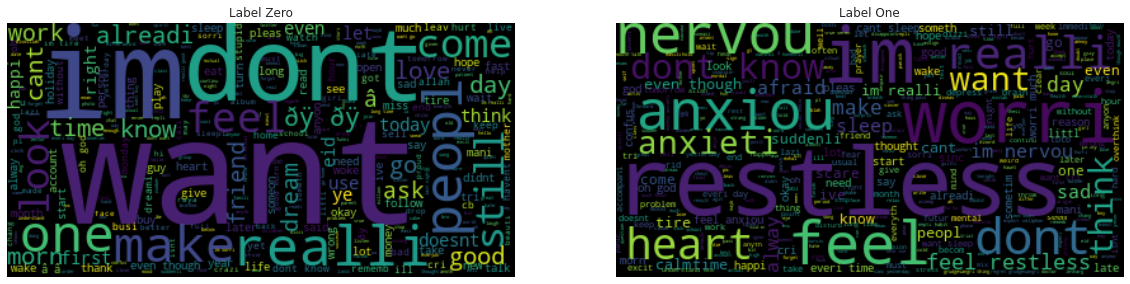

In [ ]:
script1 = " ".join(df[df['label'] == 0]['text'])
script2 = " ".join(df[df['label'] == 1]['text'])

wordcloud_nol = WordCloud(max_words=500, 
                          random_state= 42, 
                          background_color="black",
                          margin=1, 
                          colormap= 'viridis').generate(script1)

wordcloud_satu = WordCloud(max_words=500,
                           random_state= 42,
                           background_color="black", 
                           margin=1,
                           colormap= 'viridis').generate(script2)


fig, axs = plt.subplots(1,2 , figsize=(20,8)) #posisi kanan kiri 1-2 , ukuran 10,5

# Visualisasi zero 
axs[0].imshow(wordcloud_nol, interpolation='bilinear')
axs[0].axis('off') #ngilangin garis pinggir dan angka skala
axs[0].set_title('Label Zero')

#visualisasi one
axs[1].imshow(wordcloud_satu, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Label One')

plt.show()


Displays words that are often used to express **not depressed**

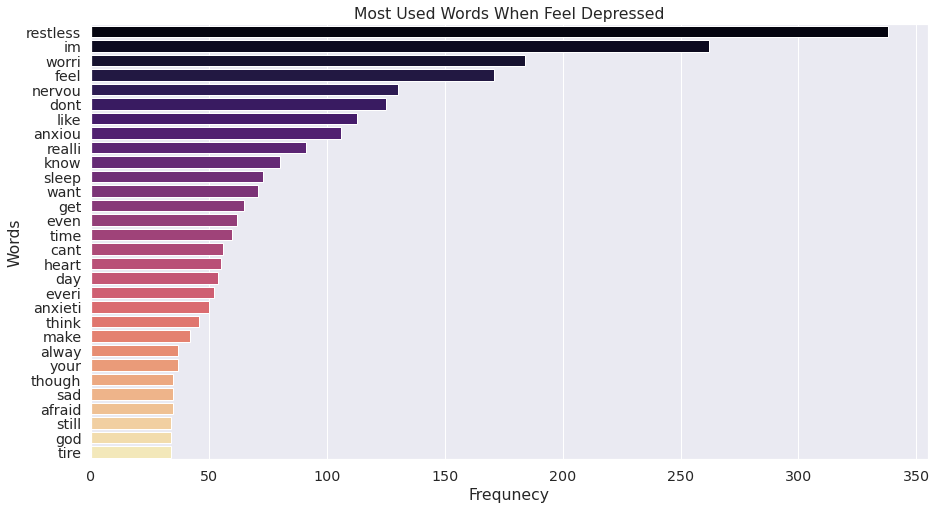

In [ ]:
nodepression_words = []
for sentence in df[df['label'] == 1]['text'].to_list():
    for word in sentence.split():
        nodepression_words.append(word)

df1 = pd.DataFrame(Counter(nodepression_words).most_common(30), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(15,8))
sns.barplot(y = df1['Word'], x= df1['Frequency'], palette= 'magma')
plt.title("Most Used Words When Feel Depressed")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

In [ ]:
df.head()

,text,label,Total Words,Length Chars,Total Words After Transformation
0,oh gosh,1.0,3,8,0.693147
1,troubl sleep confus mind restless heart tune,1.0,10,55,1.945910
2,wrong back dear forward doubt stay restless re...,1.0,14,65,2.197225
3,ive shift focu someth els im still worri,1.0,11,51,2.079442
4,im restless restless month boy mean,1.0,14,59,1.791759


**MODEL SELECTION**

For model selection, I will be building pipelines of five different classifiers and select one with the best fit results.

In this section:



*   **Vectorization** : is used to speed up the Python code without using loop. Using such a function can help in minimizing the running time of code efficiently.
*   Assigning targets and features
*   Split data into trainig and testing sets
*   The model pipelines with preprocessing:
*   Picking the best classifier.
*   Getting the confusion matrix and accuracy scores











In [ ]:
X = df['text']
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42,stratify = y)

**Term Frequency — Inverse Document Frequency atau TF — IDF** adalah suatu metode algoritma yang berguna untuk menghitung bobot setiap kata yang umum digunakan. Metode ini juga terkenal efisien, mudah dan memiliki hasil yang akurat. Metode ini akan menghitung nilai Term Frequency (TF) dan Inverse Document Frequency (IDF) pada setiap token (kata) di setiap dokumen dalam korpus. Secara sederhana, metode TF-IDF digunakan untuk mengetahui berapa sering suatu kata muncul di dalam dokumen.

In [ ]:
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Model selection process
# Build pipelines of models
pipeline_lr=Pipeline([('lr_classifier',LogisticRegression(random_state=42))])

pipeline_dt=Pipeline([ ('dt_classifier',DecisionTreeClassifier(random_state=42))])

pipeline_rf=Pipeline([('rf_classifier',RandomForestClassifier(random_state=42))])

pipeline_svc=Pipeline([('sv_classifier',SVC(random_state=42))])

pipeline_mnb=Pipeline([('nb_classifier',MultinomialNB())])

# List of five pipelines model and classifier 
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svc, pipeline_mnb]

# Dictionary of pipelines  
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest', 3: "SVC", 4: 'Multinomial Naive Bayes'}


# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

# Cross validation on accuracy 
cv_results_accuracy = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train, cv=10 )
    cv_results_accuracy.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

Logistic Regression: 0.964309 
Decision Tree: 0.984399 
RandomForest: 0.986192 
SVC: 0.979376 
Multinomial Naive Bayes: 0.932927 


**Random Forest** is the best among the models to be the most accurate model. Let's build a better random forest with grid search cv. Let's find out how it performs on testset

**MODEL EVALUATION**
*   Build a Random Forest model.
*   Create classification report.
*   Visualize the confusion matrix



In [ ]:
# Look at the test set
predict_rfc = pipeline_rf.predict(X_test)
acc1 = accuracy_score(y_test, predict_rfc)
print(acc1)

0.9899569583931134


In [ ]:
RF_model = RandomForestClassifier()
RF_model.fit(X_train, y_train)

#Test Model on test set
predict = RF_model.predict(X_test)
acc2 = accuracy_score(y_test,predict)
acc2

0.9892395982783357

In [ ]:
acc3 = accuracy_score(y_test, predict)
recall = recall_score(y_test, predict, average="weighted")
precision = precision_score(y_test, predict, average="weighted")
f1_score = f1_score(y_test, predict, average="micro")

print("%%%%%%%% Random Forest Results %%%%%%%%%")
print("Accuracy    : ", acc3)
print("Recall      : ", recall)
print("Precision   : ", precision)
print("F1 Score    : ", f1_score)

%%%%%%%% Random Forest Results %%%%%%%%%
Accuracy    :  0.9892395982783357
Recall      :  0.9892395982783357
Precision   :  0.9891598554967321
F1 Score    :  0.9892395982783357


In [ ]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1248
         1.0       0.98      0.92      0.95       146

    accuracy                           0.99      1394
   macro avg       0.98      0.96      0.97      1394
weighted avg       0.99      0.99      0.99      1394



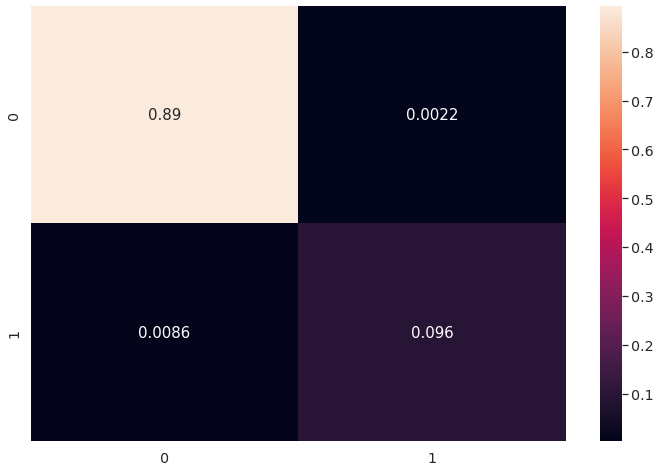

In [ ]:
# confusion matrix
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, predict)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap=None,annot = True, annot_kws = {'size':15})